# Index

1. [Defining the functions](#Defining-the-functions)
2. [Plotting the functions](#Plotting-the-functions)
3. [Optimization Algorithms](#Optimization-Algorithms)
4. [Accuracy & Efficiency](#Accuracy-&-Efficiency)
5. [Robustness](#Robustness)
6. [Closer look at Basinhopping](#Closer-look-at-Basinhopping)
7. [Discussion](#Discussion)

In [210]:
from ctf import functions2d
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize, basinhopping
from matplotlib import gridspec

matplotlib.rcParams['figure.dpi'] = 100

cmap = plt.cm.Wistia
color1 = ((166/255,86/255,40/255,1))
color2 = ((55/255,126/255,184/255,1))
color3 = ((77/255,175/255,74/255,1))
color4 = ((152/255,78/255,163/255,1))
color5 = ((255/255,127/255,0/255,1))
color6 = ((153/255,153/255,153/255,1))
color7 = ((228/255,26/255,28/255,1))
color8 = ((247/255,129/255,191/255,1))
color9 = ((255/255,255/255,51/255,1))

tol = 1e-6

basinhopping_handicap = .5
basinhopping_early_step = 10
basinhopping_T = 100

# Defining the functions
([top](#Index))

The code is from https://github.com/lukemarris/ctf

In [203]:
def minimize_callable(x):
    return fun.cost(x)

# functions
# Many Local Minima
functions = [
    # Many Local Minima
    ['Ackley', 1],
    ['Bukin6', 0],
    ['CrossInTray', 0],
    ['DropWave', 0],
    ['Eggholder', 0],
    ['Griewank', 0],
    ['HolderTable', 0],
    ['Levy13', 1],
    ['Rastrigin', 0],
    ['Schaffer2', 0],
    ['Schaffer4', 0],
    ['Schwefel', 0],
    # Bowl Shaped
    ['Shubert', 0],
    ['Bohachevsky1', 0],
    ['Bohachevsky2', 0],
    ['Bohachevsky3', 0],
    ['Perm', 0],
    ['RotatedHyperEllipsoid', 0],
    ['Sphere', 1],
    ['SumOfDifferentPowers', 0],
    ['SumSquares', 0],
    # Plate-Shaped
    ['Trid', 0],
    ['Booth', 1],
    ['Matyas', 1],
    ['McCormick', 1],
    ['PowerSum', 0],
    # Valley-Shaped
    ['Zakharov', 0],
    ['ThreeHumpCamel', 1],
    ['SixHumpCamel', 0],
    ['DixonPrice', 0],
    ['Rosenbrock', 1],
    # Steep Ridges/Drops
    ['Absolute', 1],
    ['AbsoluteSkewed', 1],
    ['DeJong5', 0],
    ['Easom', 1],
    ['Michalewicz', 0],
    ['Beale', 1],
    ['Branin', 0],
    ['GoldsteinPrice', 1],
    ['StyblinskiTang', 1]]

# functions = [
#     ['Booth', 1],
#     ['Rosenbrock', 1],
#     ['Beale', 1],
#     ['GoldsteinPrice', 1]]

#fun = functions2d.Rosenbrock()

# Plotting the functions
([top](#Index))

Below we plot the contours of different 2D functions used in the project.

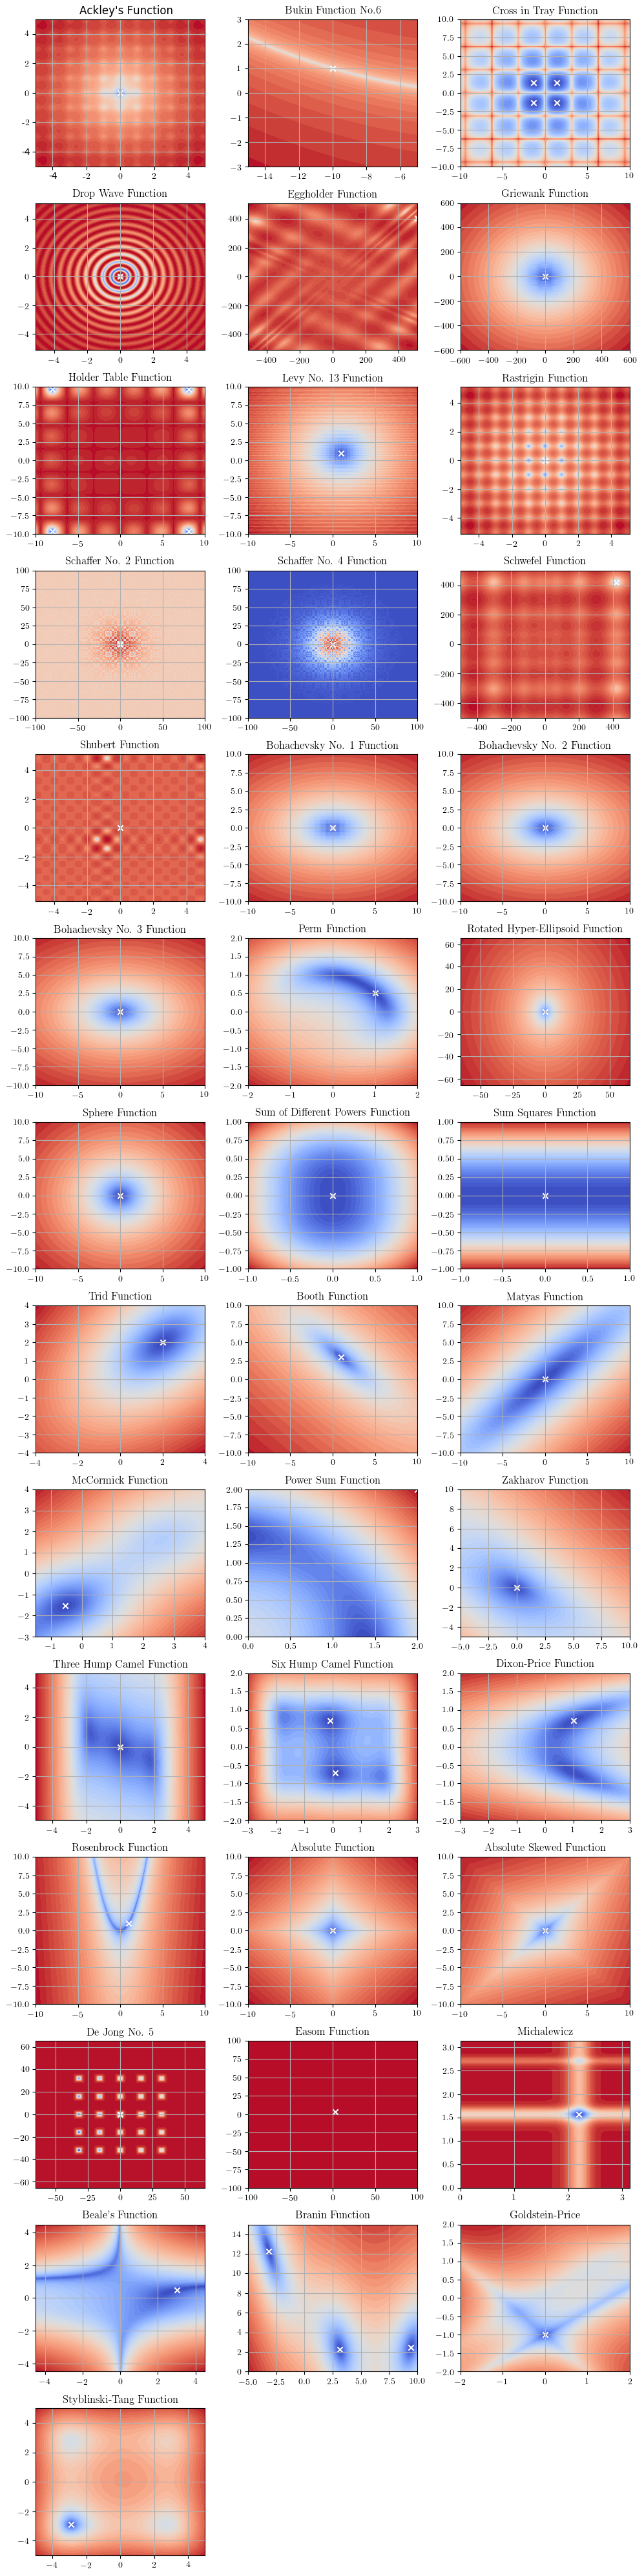

In [204]:
rows = 14
cols = 3
fig = plt.figure(figsize=(10, 40))
gs = gridspec.GridSpec(rows, cols)

row = 0
col = 0
for i in range( len(functions) ):
    target_fun = getattr(functions2d, functions[i][0])
    fun = target_fun()
    
    """ Plots the cost contour plot over the domain of the function. """
    ax = fig.add_subplot(gs[row, col])
    # Latex
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    ## Domain Correction
    # Lower x0 Limit
    if np.isfinite(fun.domain[0][0]):
        x0_lim_lower = fun.domain[0][0]
    else:
        x0_lim_lower = -10.0
    # Upper x0 Limit
    if np.isfinite(fun.domain[0][1]):
        x0_lim_upper = fun.domain[0][1]
    else:
        x0_lim_upper = +10.0
    # Lower x1 Limit
    if np.isfinite(fun.domain[1][0]):
        x1_lim_lower = fun.domain[1][0]
    else:
        x1_lim_lower = -10.0
    # Upper x1 Limit
    if np.isfinite(fun.domain[1][1]):
        x1_lim_upper = fun.domain[1][1]
    else:
        x1_lim_upper = +10.0
    
    ## Lines
    points = 200
    x0 = np.linspace(x0_lim_lower, x0_lim_upper, points)
    x1 = np.linspace(x1_lim_lower, x1_lim_upper, points)
    ## Meshes
    X0, X1 = np.meshgrid(x0, x1)
    ## Combined
    X = np.array([X0, X1])
    
    ## Calculate Costs
    cost = fun.cost(X)
    ## Renormalise
    cost_norm = np.log(cost - np.min(cost) + 1)
    
    ## Plot
    ax.contourf(X0, X1, cost_norm, 50, cmap=plt.cm.coolwarm)
    plt.scatter(fun.min[..., 0], fun.min[..., 1], c='w', marker='x')
    plt.grid()
#     plt.title(fun.latex_name + "\n" + fun.latex_cost)
    plt.title(fun.latex_name)
    plt.subplots_adjust(top=0.8)
    plt.xlim([x0_lim_lower, x0_lim_upper])
    plt.ylim([x1_lim_lower, x1_lim_upper])
        
    col = np.mod(col+1, cols)
    if col == 0:
        row = np.mod(row+1, rows)

plt.tight_layout()
plt.show()

# Optimization Algorithms
([top](#Index))



In [4]:
def cost_callable(x):
    return fun.cost(x)

def jac_callable(x):
    return fun.grad(x)

def hess_callable(x):
    return fun.hess(x)

def log_callback(*args):
    global err, fun, xk, accept
    xk.append( args[0] )
    err = np.append( err, np.linalg.norm(args[0]-fun.min) )
    # for basinhopping early stopping
    if len(args) == 3:
        accept = np.append(accept, args[2])
        if accept.shape[0] > basinhopping_early_step and \
                np.sum( accept[-basinhopping_early_step:] ) == basinhopping_early_step:
            return True

## Accuracy & Efficiency
([top](#Index))

x0= [-5.59058217  4.99861794]
Ackley's Function : global min= [ 0.  0.]
CG:  Desired error not necessarily achieved due to precision loss.
BFGS:  Optimization terminated successfully.
Newton_CG:  Optimization terminated successfully.
dogleg:  A linalg error occurred, such as a non-psd Hessian.
trust-ncg:  Optimization terminated successfully.
basinhopping:  ['callback function requested stop early byreturning True']


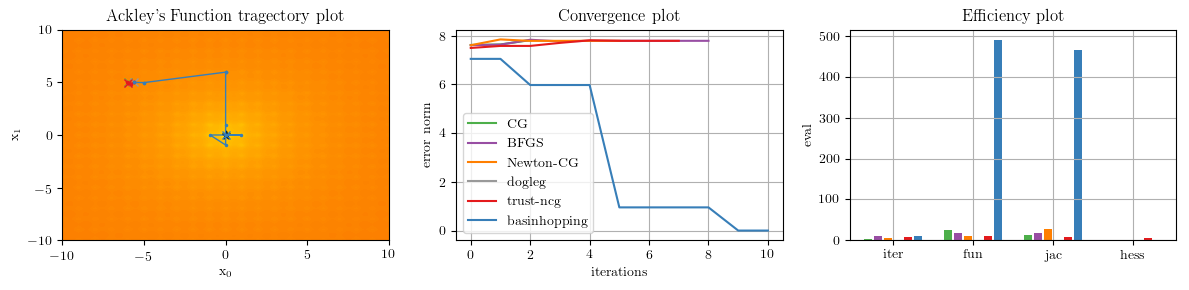

Levy No. 13 Function : global min= [ 1.  1.]
CG:  Desired error not necessarily achieved due to precision loss.
BFGS:  Desired error not necessarily achieved due to precision loss.
Newton_CG:  Warning: Desired error not necessarily achieved due to precision loss.
dogleg:  A bad approximation caused failure to predict improvement.
trust-ncg:  A bad approximation caused failure to predict improvement.
basinhopping:  ['callback function requested stop early byreturning True']


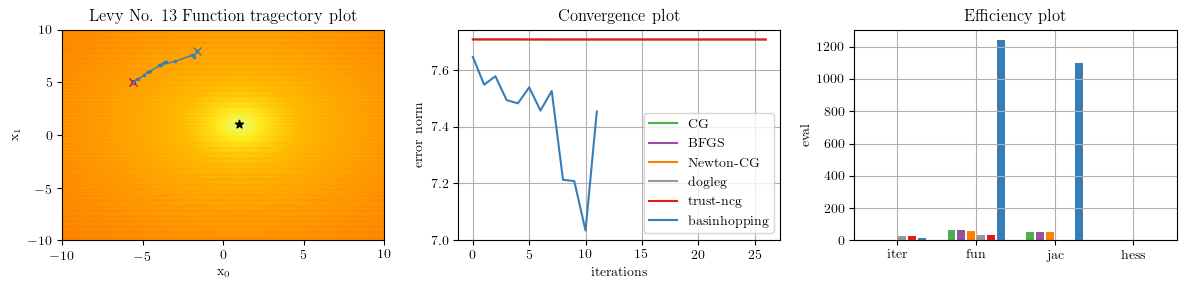

Sphere Function : global min= [ 0.  0.]
CG:  Optimization terminated successfully.
BFGS:  Optimization terminated successfully.
Newton_CG:  Optimization terminated successfully.
dogleg:  Optimization terminated successfully.
trust-ncg:  Optimization terminated successfully.
basinhopping:  ['callback function requested stop early byreturning True']


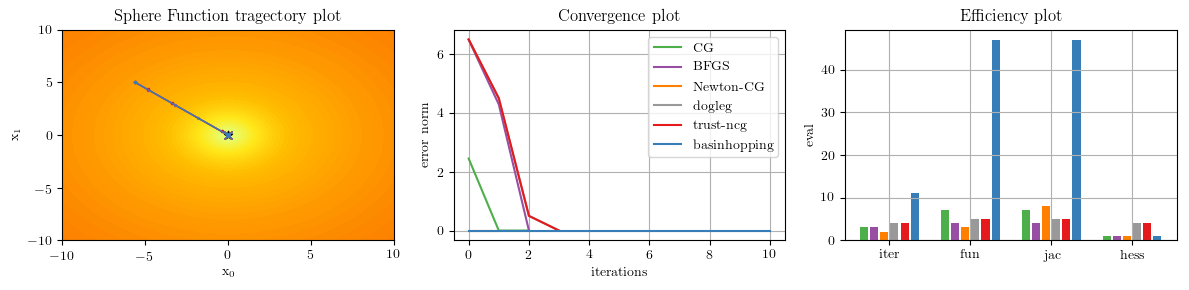

Booth Function : global min= [ 1.  3.]
CG:  Optimization terminated successfully.
BFGS:  Optimization terminated successfully.
Newton_CG:  Optimization terminated successfully.
dogleg:  Optimization terminated successfully.
trust-ncg:  Optimization terminated successfully.
basinhopping:  ['callback function requested stop early byreturning True']


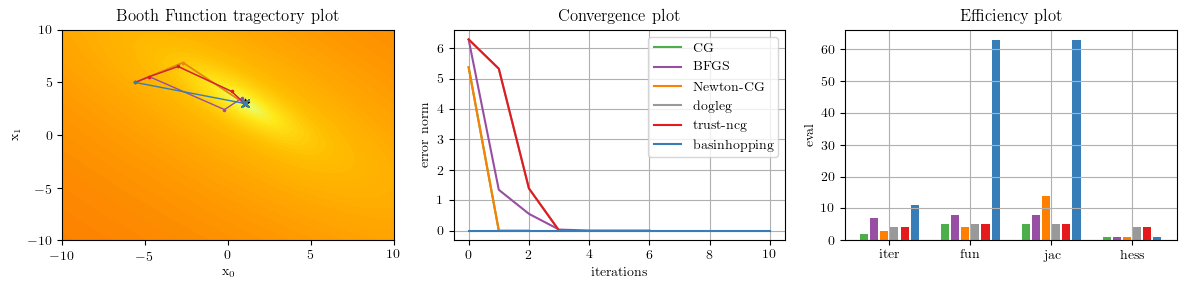

Matyas Function : global min= [ 0.  0.]
CG:  Optimization terminated successfully.
BFGS:  Optimization terminated successfully.
Newton_CG:  Optimization terminated successfully.
dogleg:  Optimization terminated successfully.
trust-ncg:  Optimization terminated successfully.
basinhopping:  ['callback function requested stop early byreturning True']


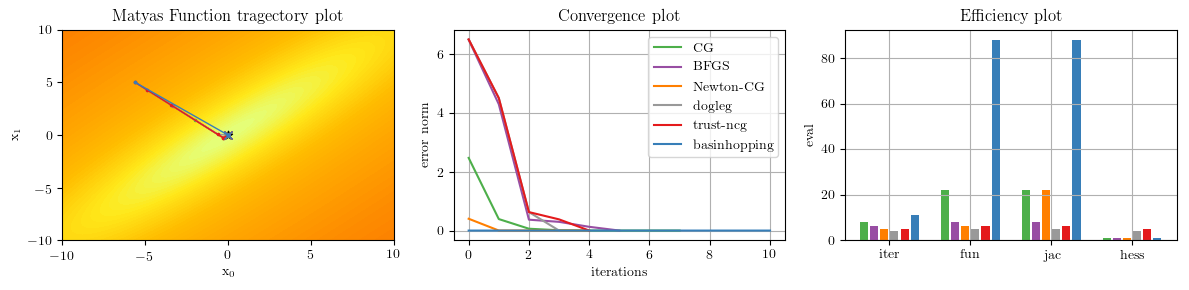

McCormick Function : global min= [-0.54719 -1.54719]
CG:  Optimization terminated successfully.
BFGS:  Optimization terminated successfully.
Newton_CG:  Optimization terminated successfully.
dogleg:  Optimization terminated successfully.
trust-ncg:  Optimization terminated successfully.
basinhopping:  ['callback function requested stop early byreturning True']


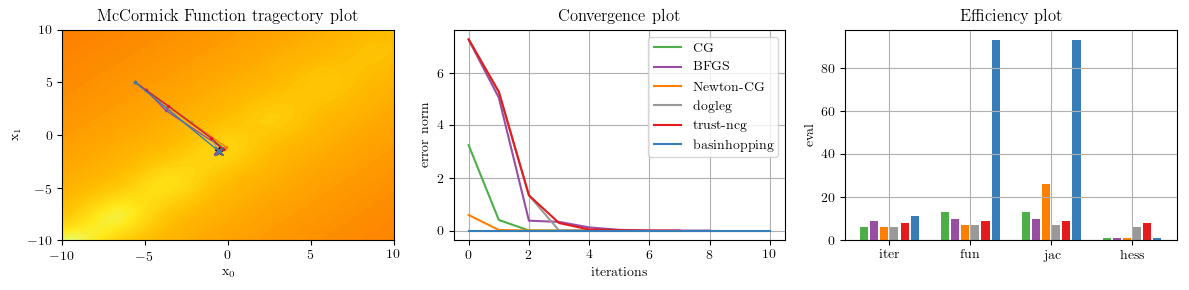

Three Hump Camel Function : global min= [ 0.  0.]
CG:  Optimization terminated successfully.
BFGS:  Optimization terminated successfully.
Newton_CG:  Optimization terminated successfully.
dogleg:  Optimization terminated successfully.
trust-ncg:  Optimization terminated successfully.
basinhopping:  ['callback function requested stop early byreturning True']


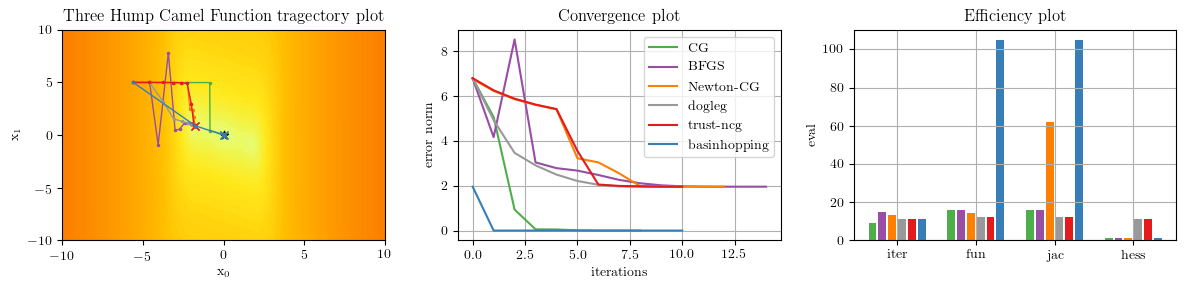

Rosenbrock Function : global min= [ 1.  1.]
CG:  Optimization terminated successfully.
BFGS:  Optimization terminated successfully.
Newton_CG:  Warning: Maximum number of iterations has been exceeded.
dogleg:  Optimization terminated successfully.
trust-ncg:  Optimization terminated successfully.
basinhopping:  ['callback function requested stop early byreturning True']


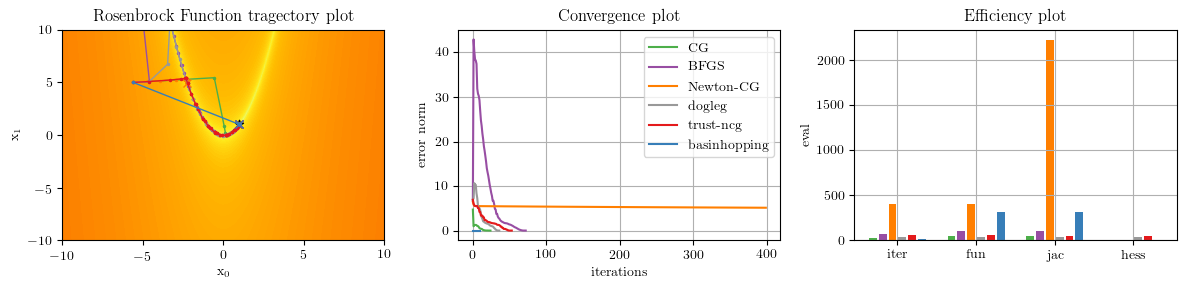

Absolute Function : global min= [ 0.  0.]
CG:  Desired error not necessarily achieved due to precision loss.
BFGS:  Desired error not necessarily achieved due to precision loss.
Newton_CG:  Optimization terminated successfully.
dogleg:  A linalg error occurred, such as a non-psd Hessian.
trust-ncg:  Maximum number of iterations has been exceeded.
basinhopping:  ['callback function requested stop early byreturning True']


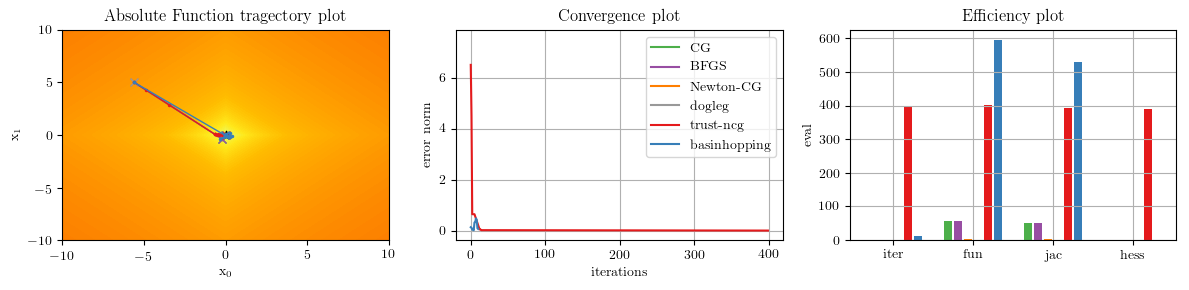

Absolute Skewed Function : global min= [ 0.  0.]
CG:  Desired error not necessarily achieved due to precision loss.
BFGS:  Desired error not necessarily achieved due to precision loss.
Newton_CG:  Optimization terminated successfully.
dogleg:  A linalg error occurred, such as a non-psd Hessian.
trust-ncg:  Maximum number of iterations has been exceeded.
basinhopping:  ['callback function requested stop early byreturning True']


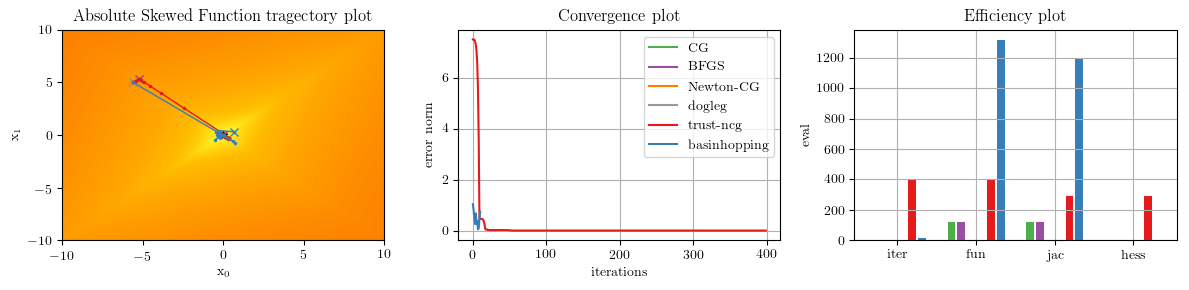

Easom Function : global min= [ 3.14159265  3.14159265]
CG:  Optimization terminated successfully.
BFGS:  Optimization terminated successfully.
Newton_CG:  Optimization terminated successfully.
dogleg:  A linalg error occurred, such as a non-psd Hessian.
trust-ncg:  Optimization terminated successfully.
basinhopping:  ['callback function requested stop early byreturning True']


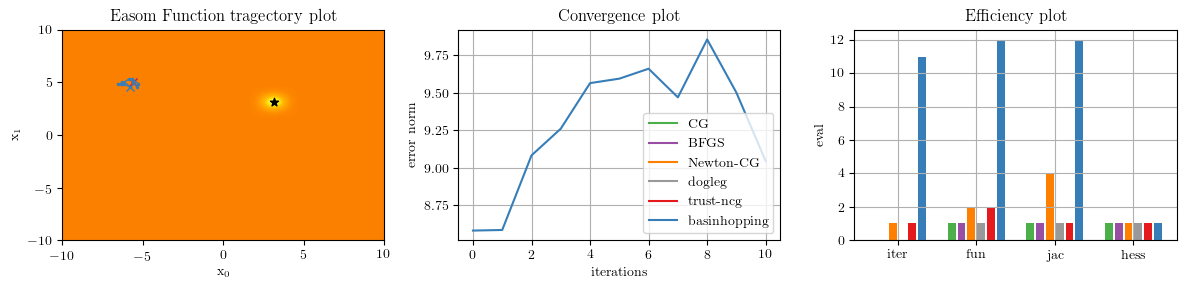

Beale's Function : global min= [ 3.   0.5]
CG:  Desired error not necessarily achieved due to precision loss.
BFGS:  Maximum number of iterations has been exceeded.
Newton_CG:  Optimization terminated successfully.
dogleg:  A linalg error occurred, such as a non-psd Hessian.
trust-ncg:  A bad approximation caused failure to predict improvement.
basinhopping:  ['callback function requested stop early byreturning True']


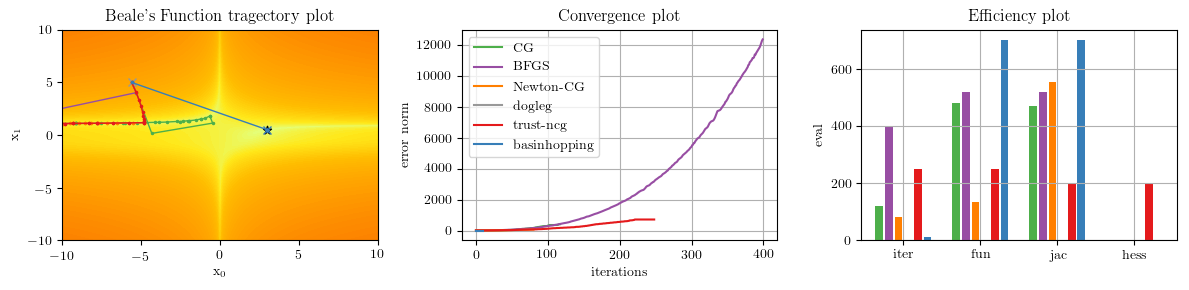

Goldstein-Price : global min= [ 0. -1.]
CG:  Optimization terminated successfully.
BFGS:  Optimization terminated successfully.
Newton_CG:  Optimization terminated successfully.
dogleg:  A linalg error occurred, such as a non-psd Hessian.
trust-ncg:  Optimization terminated successfully.
basinhopping:  ['callback function requested stop early byreturning True']


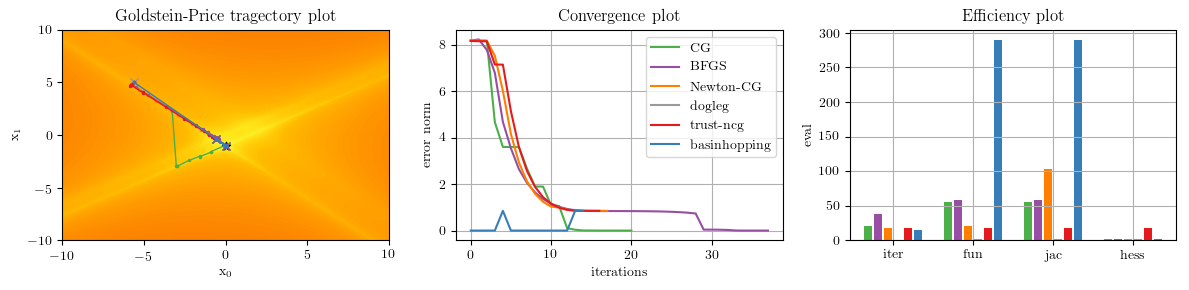

Styblinski-Tang Function : global min= [-2.903534 -2.903534]
CG:  Desired error not necessarily achieved due to precision loss.
BFGS:  Optimization terminated successfully.
Newton_CG:  Optimization terminated successfully.
dogleg:  Optimization terminated successfully.
trust-ncg:  Optimization terminated successfully.
basinhopping:  ['callback function requested stop early byreturning True']


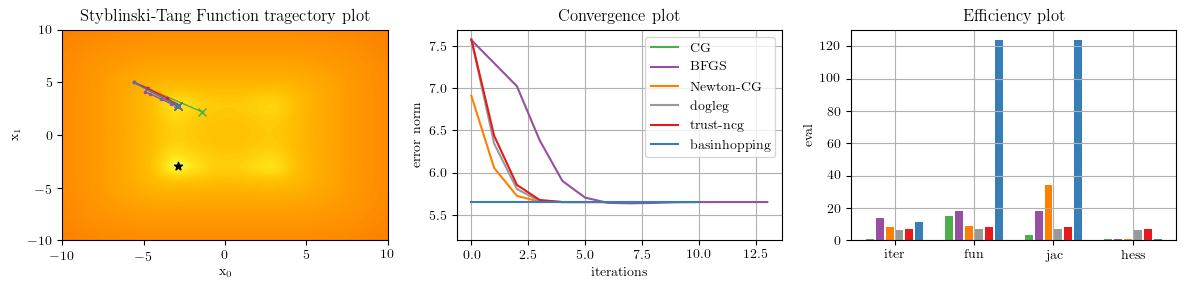

In [207]:
x0_lim_lower = -10.0
x0_lim_upper = +10.0
x1_lim_lower = -10.0
x1_lim_upper = +10.0
x0 = np.array([np.random.uniform(x0_lim_lower, x0_lim_upper, 1)[0],
               np.random.uniform(x1_lim_lower, x1_lim_upper, 1)[0]])
print('x0=', x0)

for i in range( len(functions) ):
    if not functions[i][1]:
        continue
        
    target_fun = getattr(functions2d, functions[i][0])
    fun = target_fun()
    print(fun.latex_name,': global min=', fun.min)
    
#     ## Domain Correction
#     # Lower x0 Limit
#     if np.isfinite(fun.domain[0][0]):
#         x0_lim_lower = fun.domain[0][0]
#     else:
#         x0_lim_lower = -10.0
#     # Upper x0 Limit
#     if np.isfinite(fun.domain[0][1]):
#         x0_lim_upper = fun.domain[0][1]
#     else:
#         x0_lim_upper = +10.0
#     # Lower x1 Limit
#     if np.isfinite(fun.domain[1][0]):
#         x1_lim_lower = fun.domain[1][0]
#     else:
#         x1_lim_lower = -10.0
#     # Upper x1 Limit
#     if np.isfinite(fun.domain[1][1]):
#         x1_lim_upper = fun.domain[1][1]
#     else:
#         x1_lim_upper = +10.0
    
#     x0 = np.array([np.random.uniform(x0_lim_lower, x0_lim_upper, 1)[0],
#                    np.random.uniform(x1_lim_lower, x1_lim_upper, 1)[0]])
    
    fig = plt.figure(figsize=(12, 3))
    gs = gridspec.GridSpec(1, 3)
    
    # algorithm x evals
    ev = np.zeros((6,4))
    alg = 0
    
    # run optimization
    xk = [x0]
    err = np.array([])
    res = minimize(cost_callable, x0, method='CG', tol=tol, 
                   jac=jac_callable, callback=log_callback)
    print('CG: ', res.message)
    CG_err = np.copy(err)
    CG_xk = np.copy(xk)
    ev[alg,0] = res.nit
    ev[alg,1] = res.nfev
    ev[alg,2] = res.njev
    ev[alg,3] = 1
    alg += 1

    xk = [x0]
    err = np.array([])
    res = minimize(cost_callable, x0, method='BFGS', tol=tol, 
                   jac=jac_callable, callback=log_callback)
    print('BFGS: ', res.message)
    BFGS_err = np.copy(err)
    BFGS_xk = np.copy(xk)
    ev[alg,0] = res.nit
    ev[alg,1] = res.nfev
    ev[alg,2] = res.njev
    ev[alg,3] = 1
    alg += 1

    xk = [x0]
    err = np.array([])
    res = minimize(cost_callable, x0, method='Newton-CG', tol=tol, 
                   jac=jac_callable, callback=log_callback)
    print('Newton_CG: ', res.message)
    Newton_CG_err = np.copy(err)
    Newton_CG_xk = np.copy(xk)
    ev[alg,0] = res.nit
    ev[alg,1] = res.nfev
    ev[alg,2] = res.njev
    ev[alg,3] = 1
    alg += 1

    xk = [x0]
    err = np.array([])
    res = minimize(cost_callable, x0, method='dogleg', tol=tol, 
                   jac=jac_callable, hess=hess_callable, callback=log_callback)
    print('dogleg: ', res.message)
    dogleg_err = np.copy(err)
    dogleg_xk = np.copy(xk)
    ev[alg,0] = res.nit
    ev[alg,1] = res.nfev
    ev[alg,2] = res.njev
    ev[alg,3] = res.nhev
    alg += 1

    xk = [x0]
    err = np.array([])
    res = minimize(cost_callable, x0, method='trust-ncg', tol=tol, 
                   jac=jac_callable, hess=hess_callable, callback=log_callback)
    print('trust-ncg: ', res.message)
    trust_ncg_err = np.copy(err)
    trust_ncg_xk = np.copy(xk)
    ev[alg,0] = res.nit
    ev[alg,1] = res.nfev
    ev[alg,2] = res.njev
    ev[alg,3] = res.nhev
    alg += 1

    xk = [x0]
    err = np.array([])
    accept = np.array([])
    res = basinhopping(cost_callable, x0, callback=log_callback, T=basinhopping_T,
                       minimizer_kwargs={'method': 'BFGS', 'jac': jac_callable, 'tol': tol})
    print('basinhopping: ', res.message)
    basinhopping_err= np.copy(err)
    basinhopping_xk = np.copy(xk)
    ev[alg,0] = res.nit
    ev[alg,1] = res.nfev
    ev[alg,2] = res.njev
    ev[alg,3] = 1
    alg += 1
    
    # tragectory plot
    ax2 = fig.add_subplot(gs[0, 0])
    ## Lines
    points = 200
    x00 = np.linspace(x0_lim_lower, x0_lim_upper, points)
    x11 = np.linspace(x1_lim_lower, x1_lim_upper, points)
    ## Meshes
    X0, X1 = np.meshgrid(x00, x11)
    ## Combined
    X = np.array([X0, X1])
    
    ## Calculate Costs
    cost = fun.cost(X)
    ## Renormalise
    cost_norm = np.log(cost - np.min(cost) + 1)
    
    ## Plot
    ax2.contourf(X0, X1, cost_norm, 50, cmap=cmap)
    plt.scatter(fun.min[..., 0], fun.min[..., 1], c='k', marker='*')
    
    plt.plot(CG_xk[:,0], CG_xk[:,1], '.-', markersize=3, linewidth=1, color=color3)
    plt.plot(CG_xk[-1,0], CG_xk[-1,1], 'x', color=color3)

    plt.plot(BFGS_xk[:,0], BFGS_xk[:,1], '.-', markersize=3, linewidth=1, color=color4)
    plt.plot(BFGS_xk[-1,0], BFGS_xk[-1,1], 'x', color=color4)

    plt.plot(Newton_CG_xk[:,0], Newton_CG_xk[:,1], '.-', markersize=3, linewidth=1, color=color5)
    plt.plot(Newton_CG_xk[-1,0], Newton_CG_xk[-1,1], 'x', color=color5)

    plt.plot(dogleg_xk[:,0], dogleg_xk[:,1], '.-', markersize=3, linewidth=1, color=color6)
    plt.plot(dogleg_xk[-1,0], dogleg_xk[-1,1], 'x', color=color6)

    plt.plot(trust_ncg_xk[:,0], trust_ncg_xk[:,1], '.-', markersize=3, linewidth=1, color=color7)
    plt.plot(trust_ncg_xk[-1,0], trust_ncg_xk[-1,1], 'x', color=color7)

    plt.plot(basinhopping_xk[:,0], basinhopping_xk[:,1], '.-', markersize=3, linewidth=1, color=color2)
    plt.plot(basinhopping_xk[-1,0], basinhopping_xk[-1,1], 'x', color=color2)

#     plt.grid()
#     plt.title(fun.latex_name + "\n" + fun.latex_cost)
    plt.title(fun.latex_name+' tragectory plot')
    plt.subplots_adjust(top=0.8)
    plt.xlim([x0_lim_lower, x0_lim_upper])
    plt.ylim([x1_lim_lower, x1_lim_upper])
    plt.xlabel('x_0')
    plt.ylabel('x_1')
    
    # convergence plot
    ax1 = fig.add_subplot(gs[0, 1])
    plt.plot(CG_err, color=color3)
    plt.plot(BFGS_err, color=color4)
    plt.plot(Newton_CG_err, color=color5)
    plt.plot(dogleg_err, color=color6)
    plt.plot(trust_ncg_err, color=color7)
    plt.plot(basinhopping_err, color=color2)
    plt.title('Convergence plot')
    plt.xlabel('iterations')
    plt.ylabel('error norm')
    plt.subplots_adjust(top=0.8)
    plt.grid()
    plt.legend(['CG', 'BFGS', 'Newton-CG', 'dogleg', 'trust-ncg', 'basinhopping'])
    
    # efficiency
    ax3 = fig.add_subplot(gs[0, 2])
    x = np.arange(4)*2
#     ev = np.log10(ev)
    ax3.bar(x, ev[0,:], color=color3, width=.2)
    ax3.bar(x+.25, ev[1,:], color=color4, width=.2)
    ax3.bar(x+.5, ev[2,:], color=color5, width=.2)
    ax3.bar(x+.75, ev[3,:], color=color6, width=.2)
    ax3.bar(x+1, ev[4,:], color=color7, width=.2)
    ax3.bar(x+1.25, ev[5,:], color=color2, width=.2)
    plt.xticks(x+.625, ['iter', 'fun', 'jac', 'hess'])
    plt.title('Efficiency plot')
    plt.ylabel('#eval')
    plt.subplots_adjust(top=0.8)
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    
    

## Robustness
([top](#Index))

Message (Newton-CG):  free variable 'gfk' referenced before assignment in enclosing scope
Message (Newton-CG):  free variable 'gfk' referenced before assignment in enclosing scope
Message (Newton-CG):  free variable 'gfk' referenced before assignment in enclosing scope


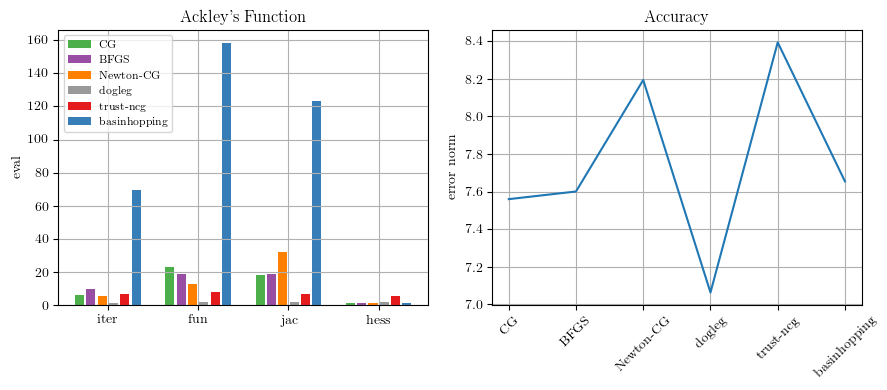

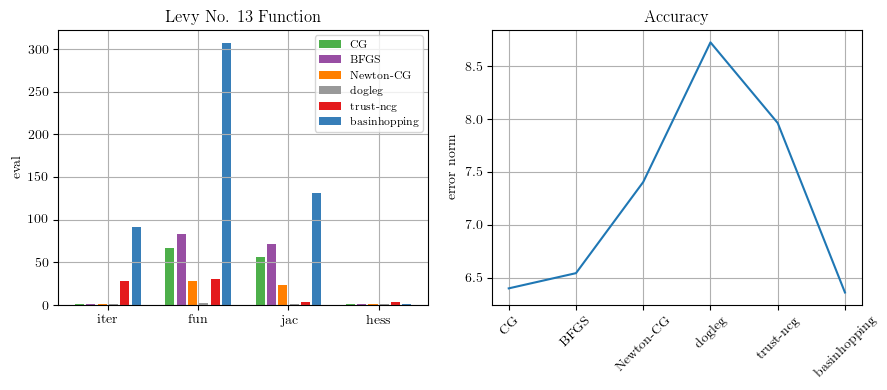

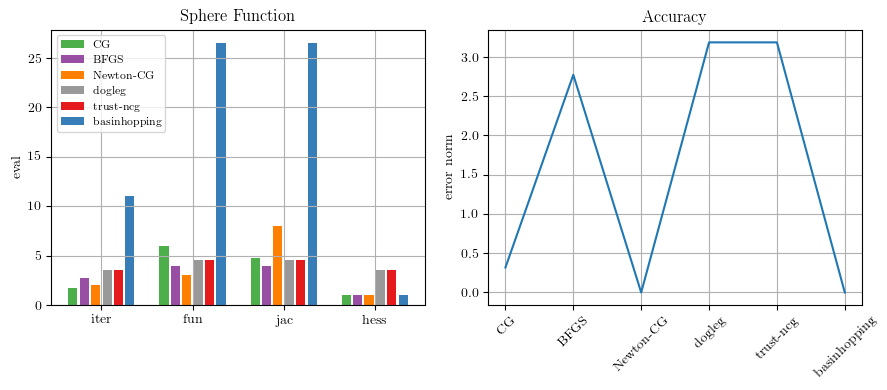

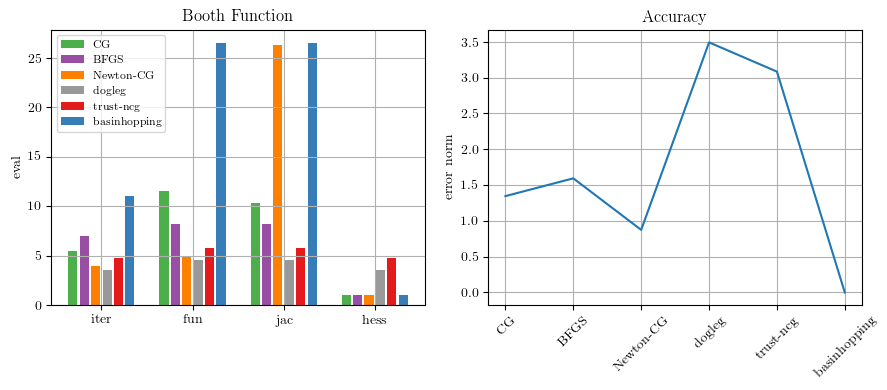

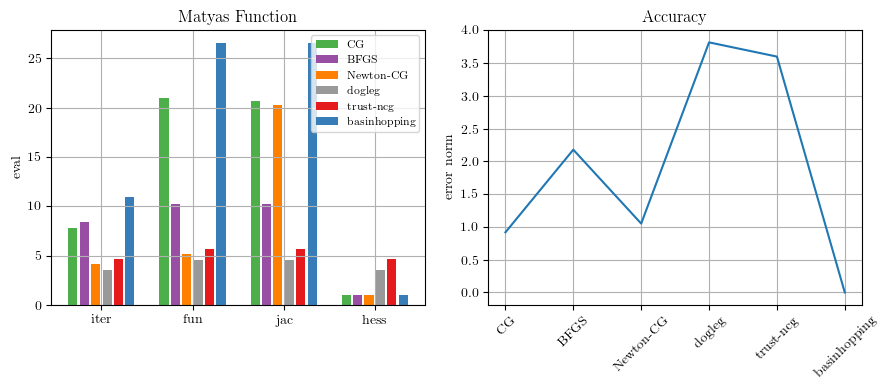

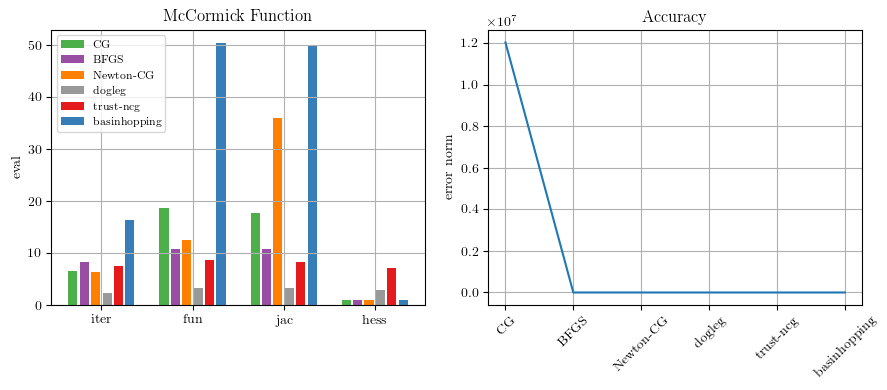

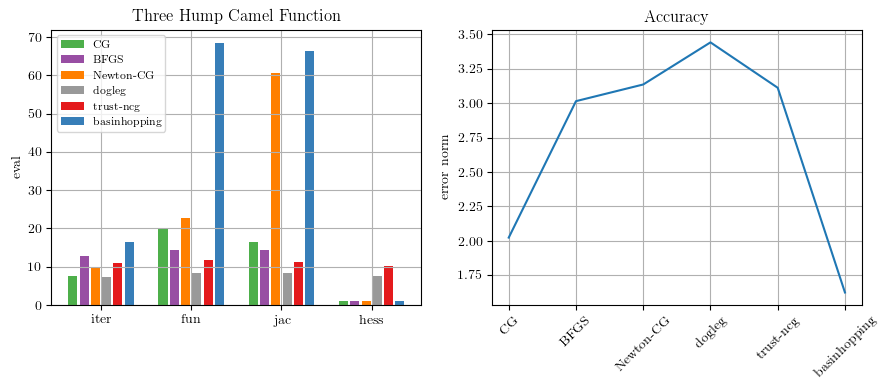

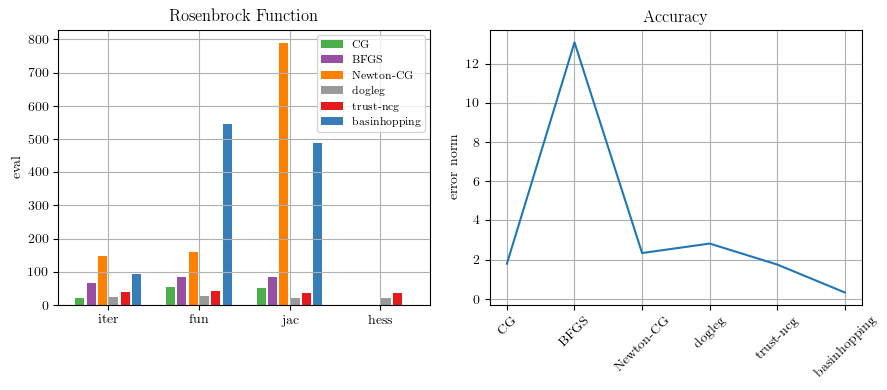

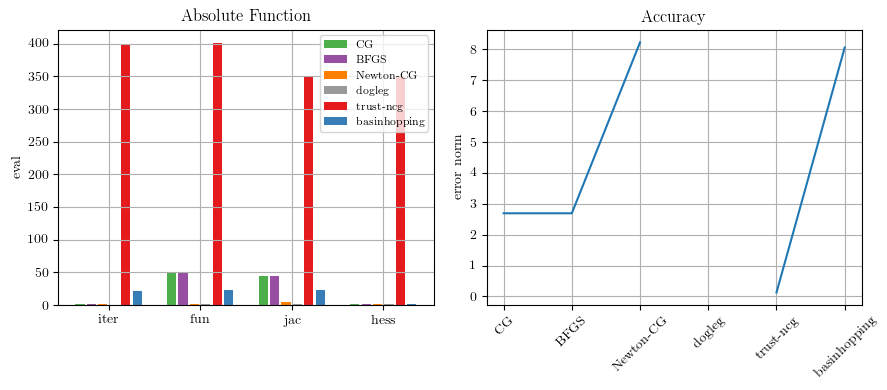

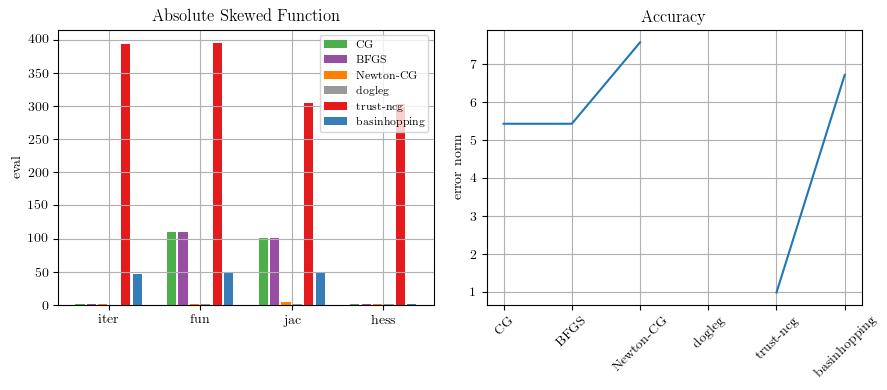

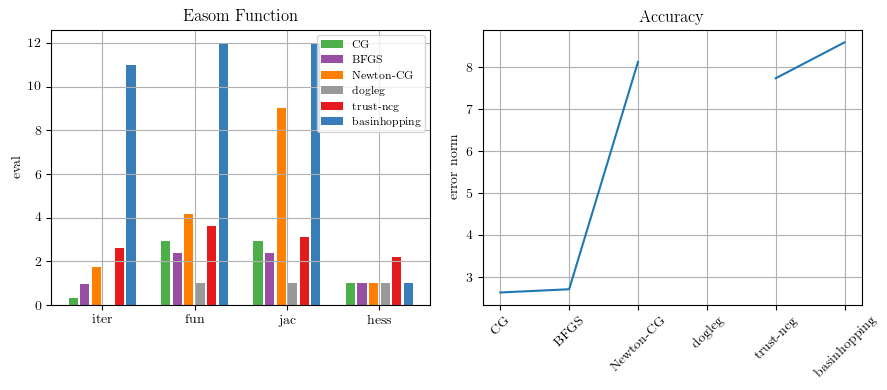

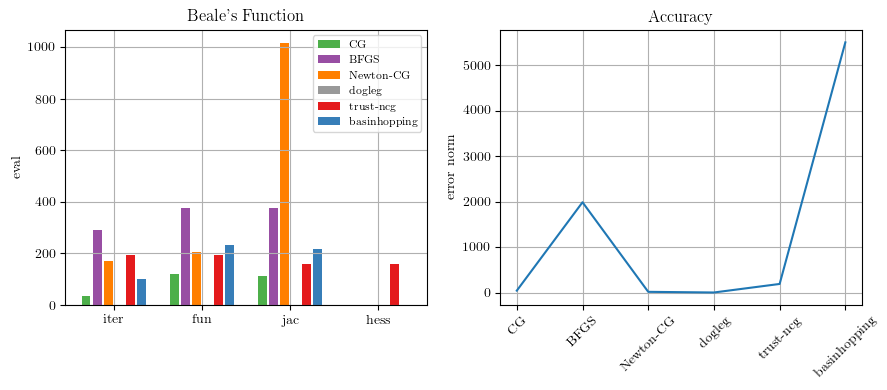

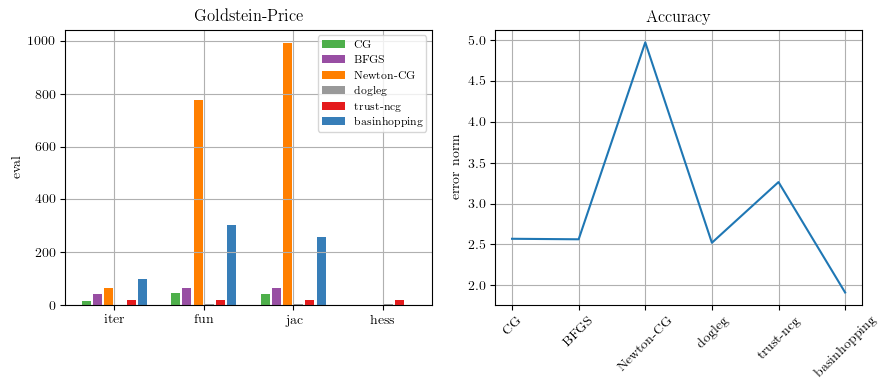

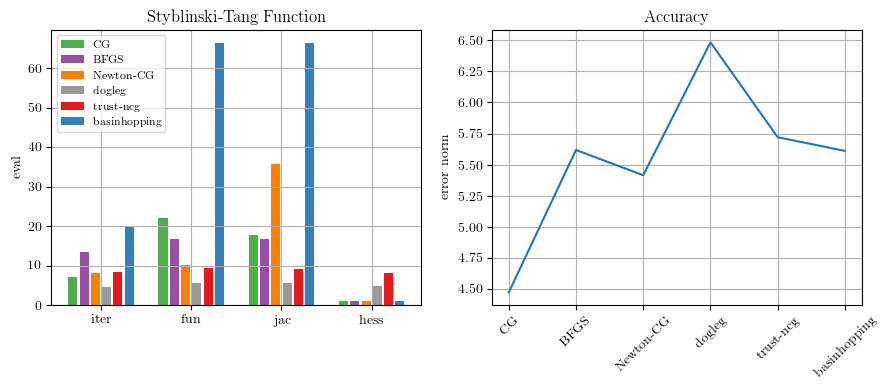

In [219]:
repeats = 40
algorithms = 6
measures = 5
# functions_robust = [
# #         ['Ackley', 1]
# #         ['Booth', 1]
#         ['Beale', 1]
#     ]
functions_robust = functions

ev = np.zeros((algorithms, measures, len(functions_robust), repeats))
for j in range(repeats):
    for i in range( len(functions_robust) ):
        if not functions_robust[i][1]:
            continue
        
        target_fun = getattr(functions2d, functions_robust[i][0])
        fun = target_fun()
        
        # algorithm x evals
        alg = 0

#         ## Domain Correction
#         # Lower x0 Limit
#         if np.isfinite(fun.domain[0][0]):
#             x0_lim_lower = fun.domain[0][0]
#         else:
#             x0_lim_lower = -10.0
#         # Upper x0 Limit
#         if np.isfinite(fun.domain[0][1]):
#             x0_lim_upper = fun.domain[0][1]
#         else:
#             x0_lim_upper = +10.0
#         # Lower x1 Limit
#         if np.isfinite(fun.domain[1][0]):
#             x1_lim_lower = fun.domain[1][0]
#         else:
#             x1_lim_lower = -10.0
#         # Upper x1 Limit
#         if np.isfinite(fun.domain[1][1]):
#             x1_lim_upper = fun.domain[1][1]
#         else:
#             x1_lim_upper = +10.0

#         x0 = np.array([np.random.uniform(x0_lim_lower, x0_lim_upper, 1)[0],
#                        np.random.uniform(x1_lim_lower, x1_lim_upper, 1)[0]])
        
        x0_lim_lower = -10.0
        x0_lim_upper = +10.0
        x1_lim_lower = -10.0
        x1_lim_upper = +10.0
        x0 = np.array([np.random.uniform(x0_lim_lower, x0_lim_upper, 1)[0],
                       np.random.uniform(x1_lim_lower, x1_lim_upper, 1)[0]])
        
#         print('repeat ', j, 'function ', fun.latex_name, ', x0=', x0)
        
        # run optimization
        xk = [x0]
        err = np.array([])
        res = minimize(cost_callable, x0, method='CG', tol=tol, 
                       jac=jac_callable, callback=log_callback)
#         print('CG: ', res.message)
        ev[alg,0,i,j] = res.nit
        ev[alg,1,i,j] = res.nfev
        ev[alg,2,i,j] = res.njev
        ev[alg,3,i,j] = 1
        ev[alg,4,i,j] = np.mean(err)
        alg += 1

        xk = [x0]
        err = np.array([])
        res = minimize(cost_callable, x0, method='BFGS', tol=tol, 
                       jac=jac_callable, callback=log_callback)
#         print('BFGS: ', res.message)
        ev[alg,0,i,j] = res.nit
        ev[alg,1,i,j] = res.nfev
        ev[alg,2,i,j] = res.njev
        ev[alg,3,i,j] = 1
        ev[alg,4,i,j] = np.mean(err)
        alg += 1

        xk = [x0]
        err = np.array([])
        try:
            res = minimize(cost_callable, x0, method='Newton-CG', tol=tol, 
                       jac=jac_callable, callback=log_callback)
            ev[alg,0,i,j] = res.nit
            ev[alg,1,i,j] = res.nfev
            ev[alg,2,i,j] = res.njev
            ev[alg,3,i,j] = res.nhev
            ev[alg,4,i,j] = np.mean(err)
        except Exception as e:
            print('Message (Newton-CG): ', str(e))
            ev[alg,0,i,j] = np.nan
            ev[alg,1,i,j] = np.nan
            ev[alg,2,i,j] = np.nan
            ev[alg,3,i,j] = np.nan
            ev[alg,4,i,j] = np.nan
#         print('Newton_CG: ', res.message)
        ev[alg,0,i,j] = res.nit
        ev[alg,1,i,j] = res.nfev
        ev[alg,2,i,j] = res.njev
        ev[alg,3,i,j] = 1
        ev[alg,4,i,j] = np.mean(err)
        alg += 1

        xk = [x0]
        err = np.array([])
        res = minimize(cost_callable, x0, method='dogleg', tol=tol, 
                       jac=jac_callable, hess=hess_callable, callback=log_callback)
#         print('dogleg: ', res.message)
        ev[alg,0,i,j] = res.nit
        ev[alg,1,i,j] = res.nfev
        ev[alg,2,i,j] = res.njev
        ev[alg,3,i,j] = res.nhev
        ev[alg,4,i,j] = np.mean(err)
        alg += 1

        xk = [x0]
        err = np.array([])
        try:
            res = minimize(cost_callable, x0, method='trust-ncg', tol=tol, 
                       jac=jac_callable, hess=hess_callable, callback=log_callback)
            ev[alg,0,i,j] = res.nit
            ev[alg,1,i,j] = res.nfev
            ev[alg,2,i,j] = res.njev
            ev[alg,3,i,j] = res.nhev
            ev[alg,4,i,j] = np.mean(err)
        except Exception as e:
            print('Message (trust-ncg): ', str(e))
            ev[alg,0,i,j] = np.nan
            ev[alg,1,i,j] = np.nan
            ev[alg,2,i,j] = np.nan
            ev[alg,3,i,j] = np.nan
            ev[alg,4,i,j] = np.nan
#         print('trust-ncg: ', res.message)
        alg += 1

        xk = [x0]
        err = np.array([])
        accept = np.array([])
        res = basinhopping(cost_callable, x0, callback=log_callback, T=1,
                           minimizer_kwargs={'method': 'dogleg', 'jac': jac_callable, 'hess': hess_callable, 'tol': tol})
#         print('basinhopping: ', res.message)
        ev[alg,0,i,j] = res.nit
        ev[alg,1,i,j] = res.nfev
        ev[alg,2,i,j] = res.njev
        ev[alg,3,i,j] = 1
        ev[alg,4,i,j] = np.mean(err)
        alg += 1

for i in range( len(functions_robust) ):
    if not functions_robust[i][1]:
            continue
        
    fig = plt.figure(figsize=(9, 4))
    gs = gridspec.GridSpec(1, 2)

    ylabels = ['']

    # efficiency
    target_fun = getattr(functions2d, functions_robust[i][0])
    fun = target_fun()

    bars = np.mean(ev[:,:-1,i,:], axis=2)
    ax3 = fig.add_subplot(gs[0])
    x = np.arange(bars.shape[1])*2
    # bars = np.log10(bars)
    ax3.bar(x, bars[0,:], color=color3, width=.2)
    ax3.bar(x+.25, bars[1,:], color=color4, width=.2)
    ax3.bar(x+.5, bars[2,:], color=color5, width=.2)
    ax3.bar(x+.75, bars[3,:], color=color6, width=.2)
    ax3.bar(x+1, bars[4,:], color=color7, width=.2)
    ax3.bar(x+1.25, bars[5,:], color=color2, width=.2)
    plt.xticks(x+.625, ['iter', 'fun', 'jac', 'hess'])
    plt.title(fun.latex_name)
    plt.ylabel('#eval')
    plt.subplots_adjust(top=0.8)
    plt.grid()
    plt.legend(['CG', 'BFGS', 'Newton-CG', 'dogleg', 'trust-ncg', 'basinhopping'], fontsize=8)

    errs = np.nanmean(ev[:,-1,i,:], axis=1)
    stds = np.nanmean(ev[:,-1,i,:], axis=1)
    ax3 = fig.add_subplot(gs[1])
    # for i in range(6):
#     plt.errorbar(range(6), errs, yerr=stds, uplims=True, lolims=True)
    plt.plot(range(6), errs)
    plt.title('Accuracy')
    plt.xticks(np.arange(6), ['CG', 'BFGS', 'Newton-CG', 'dogleg', 'trust-ncg', 'basinhopping'], rotation=45)
    plt.ylabel('error norm')
    plt.subplots_adjust(top=0.8)
    plt.grid()    

    plt.tight_layout()
    plt.show()

# Closer look at Basinhopping
([top](#Index))

x0= [-5.88794427  8.65245952]
Rosenbrock Function : global min= [ 1.  1.]
CG:  Desired error not necessarily achieved due to precision loss.
BFGS:  Optimization terminated successfully.
Newton_CG:  Warning: Maximum number of iterations has been exceeded.
dogleg:  Optimization terminated successfully.
trust-ncg:  Optimization terminated successfully.
basinhopping:  ['callback function requested stop early byreturning True']


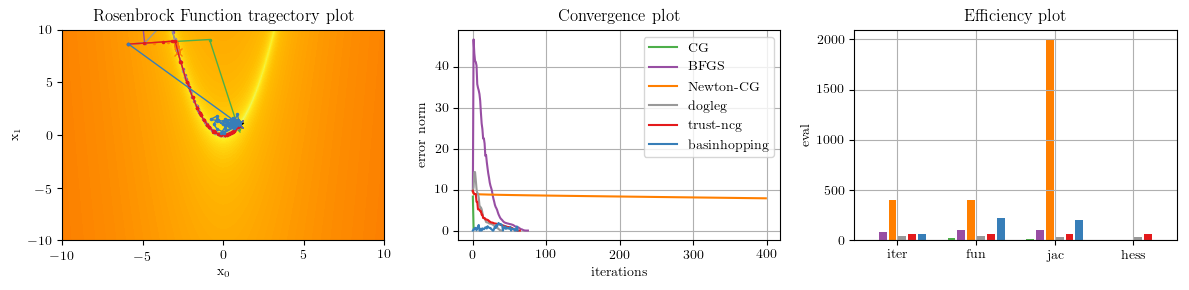

In [218]:
x0_lim_lower = -10.0
x0_lim_upper = +10.0
x1_lim_lower = -10.0
x1_lim_upper = +10.0
x0 = np.array([np.random.uniform(x0_lim_lower, x0_lim_upper, 1)[0],
               np.random.uniform(x1_lim_lower, x1_lim_upper, 1)[0]])
print('x0=', x0)

target_fun = getattr(functions2d, 'Rosenbrock')
fun = target_fun()
print(fun.latex_name,': global min=', fun.min)

#     ## Domain Correction
#     # Lower x0 Limit
#     if np.isfinite(fun.domain[0][0]):
#         x0_lim_lower = fun.domain[0][0]
#     else:
#         x0_lim_lower = -10.0
#     # Upper x0 Limit
#     if np.isfinite(fun.domain[0][1]):
#         x0_lim_upper = fun.domain[0][1]
#     else:
#         x0_lim_upper = +10.0
#     # Lower x1 Limit
#     if np.isfinite(fun.domain[1][0]):
#         x1_lim_lower = fun.domain[1][0]
#     else:
#         x1_lim_lower = -10.0
#     # Upper x1 Limit
#     if np.isfinite(fun.domain[1][1]):
#         x1_lim_upper = fun.domain[1][1]
#     else:
#         x1_lim_upper = +10.0

#     x0 = np.array([np.random.uniform(x0_lim_lower, x0_lim_upper, 1)[0],
#                    np.random.uniform(x1_lim_lower, x1_lim_upper, 1)[0]])

fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 3)

# algorithm x evals
ev = np.zeros((6,4))
alg = 0

# run optimization
xk = [x0]
err = np.array([])
res = minimize(cost_callable, x0, method='CG', tol=tol, 
               jac=jac_callable, callback=log_callback)
print('CG: ', res.message)
CG_err = np.copy(err)
CG_xk = np.copy(xk)
ev[alg,0] = res.nit
ev[alg,1] = res.nfev
ev[alg,2] = res.njev
ev[alg,3] = 1
alg += 1

xk = [x0]
err = np.array([])
res = minimize(cost_callable, x0, method='BFGS', tol=tol, 
               jac=jac_callable, callback=log_callback)
print('BFGS: ', res.message)
BFGS_err = np.copy(err)
BFGS_xk = np.copy(xk)
ev[alg,0] = res.nit
ev[alg,1] = res.nfev
ev[alg,2] = res.njev
ev[alg,3] = 1
alg += 1

xk = [x0]
err = np.array([])
res = minimize(cost_callable, x0, method='Newton-CG', tol=tol, 
               jac=jac_callable, callback=log_callback)
print('Newton_CG: ', res.message)
Newton_CG_err = np.copy(err)
Newton_CG_xk = np.copy(xk)
ev[alg,0] = res.nit
ev[alg,1] = res.nfev
ev[alg,2] = res.njev
ev[alg,3] = 1
alg += 1

xk = [x0]
err = np.array([])
res = minimize(cost_callable, x0, method='dogleg', tol=tol, 
               jac=jac_callable, hess=hess_callable, callback=log_callback)
print('dogleg: ', res.message)
dogleg_err = np.copy(err)
dogleg_xk = np.copy(xk)
ev[alg,0] = res.nit
ev[alg,1] = res.nfev
ev[alg,2] = res.njev
ev[alg,3] = res.nhev
alg += 1

xk = [x0]
err = np.array([])
res = minimize(cost_callable, x0, method='trust-ncg', tol=tol, 
               jac=jac_callable, hess=hess_callable, callback=log_callback)
print('trust-ncg: ', res.message)
trust_ncg_err = np.copy(err)
trust_ncg_xk = np.copy(xk)
ev[alg,0] = res.nit
ev[alg,1] = res.nfev
ev[alg,2] = res.njev
ev[alg,3] = res.nhev
alg += 1

xk = [x0]
err = np.array([])
accept = np.array([])
res = basinhopping(cost_callable, x0, callback=log_callback, T=basinhopping_T,
                   minimizer_kwargs={'method': 'dogleg', 'jac': jac_callable, 'hess': hess_callable, 'tol': tol})
print('basinhopping: ', res.message)
basinhopping_err= np.copy(err)
basinhopping_xk = np.copy(xk)
ev[alg,0] = res.nit
ev[alg,1] = res.nfev
ev[alg,2] = res.njev
ev[alg,3] = 1
alg += 1

# tragectory plot
ax2 = fig.add_subplot(gs[0, 0])
## Lines
points = 200
x00 = np.linspace(x0_lim_lower, x0_lim_upper, points)
x11 = np.linspace(x1_lim_lower, x1_lim_upper, points)
## Meshes
X0, X1 = np.meshgrid(x00, x11)
## Combined
X = np.array([X0, X1])

## Calculate Costs
cost = fun.cost(X)
## Renormalise
cost_norm = np.log(cost - np.min(cost) + 1)

## Plot
ax2.contourf(X0, X1, cost_norm, 50, cmap=cmap)
plt.scatter(fun.min[..., 0], fun.min[..., 1], c='k', marker='*')

plt.plot(CG_xk[:,0], CG_xk[:,1], '.-', markersize=3, linewidth=1, color=color3)
plt.plot(CG_xk[-1,0], CG_xk[-1,1], 'x', color=color3)

plt.plot(BFGS_xk[:,0], BFGS_xk[:,1], '.-', markersize=3, linewidth=1, color=color4)
plt.plot(BFGS_xk[-1,0], BFGS_xk[-1,1], 'x', color=color4)

plt.plot(Newton_CG_xk[:,0], Newton_CG_xk[:,1], '.-', markersize=3, linewidth=1, color=color5)
plt.plot(Newton_CG_xk[-1,0], Newton_CG_xk[-1,1], 'x', color=color5)

plt.plot(dogleg_xk[:,0], dogleg_xk[:,1], '.-', markersize=3, linewidth=1, color=color6)
plt.plot(dogleg_xk[-1,0], dogleg_xk[-1,1], 'x', color=color6)

plt.plot(trust_ncg_xk[:,0], trust_ncg_xk[:,1], '.-', markersize=3, linewidth=1, color=color7)
plt.plot(trust_ncg_xk[-1,0], trust_ncg_xk[-1,1], 'x', color=color7)

plt.plot(basinhopping_xk[:,0], basinhopping_xk[:,1], '.-', markersize=3, linewidth=1, color=color2)
plt.plot(basinhopping_xk[-1,0], basinhopping_xk[-1,1], 'x', color=color2)

#     plt.grid()
#     plt.title(fun.latex_name + "\n" + fun.latex_cost)
plt.title(fun.latex_name+' tragectory plot')
plt.subplots_adjust(top=0.8)
plt.xlim([x0_lim_lower, x0_lim_upper])
plt.ylim([x1_lim_lower, x1_lim_upper])
plt.xlabel('x_0')
plt.ylabel('x_1')

# convergence plot
ax1 = fig.add_subplot(gs[0, 1])
plt.plot(CG_err, color=color3)
plt.plot(BFGS_err, color=color4)
plt.plot(Newton_CG_err, color=color5)
plt.plot(dogleg_err, color=color6)
plt.plot(trust_ncg_err, color=color7)
plt.plot(basinhopping_err, color=color2)
plt.title('Convergence plot')
plt.xlabel('iterations')
plt.ylabel('error norm')
plt.subplots_adjust(top=0.8)
plt.grid()
plt.legend(['CG', 'BFGS', 'Newton-CG', 'dogleg', 'trust-ncg', 'basinhopping'])

# efficiency
ax3 = fig.add_subplot(gs[0, 2])
x = np.arange(4)*2
#     ev = np.log10(ev)
ax3.bar(x, ev[0,:], color=color3, width=.2)
ax3.bar(x+.25, ev[1,:], color=color4, width=.2)
ax3.bar(x+.5, ev[2,:], color=color5, width=.2)
ax3.bar(x+.75, ev[3,:], color=color6, width=.2)
ax3.bar(x+1, ev[4,:], color=color7, width=.2)
ax3.bar(x+1.25, ev[5,:], color=color2, width=.2)
plt.xticks(x+.625, ['iter', 'fun', 'jac', 'hess'])
plt.title('Efficiency plot')
plt.ylabel('#eval')
plt.subplots_adjust(top=0.8)
plt.grid()

plt.tight_layout()
plt.show()



# Discussion
([top](#Index))

* We tried to minimize 14 functions (some of them nasty) using deterministic algorithms available from SciPy, and a hybrid algorithm (Basinhopping). There are 26 more which do not implement the gradient or hessian.
* All of the SciPy optimization routines implement a `callback` method at each iteration. We used the method to log the local minima and error norm. In case of Basinhopping, we also implemented an early stopping criteria.
* It will be informative to log the optimization status returned by SciPy.
* In terms of robustness, Basinhopping error is lower than the other algorithms except in case of Beale's function.
* In terms of efficiency, basinhopping fares better using dogleg for local optimization.
* Some common error messages:
    * 
